In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
# 2a. K-means, choosing best k using silhouettes score

calls = pd.read_csv('../../Homework Data/Homework 5 Data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
X = calls.iloc[:, :22]
y = calls.iloc[:, 22:25]

In [3]:
from sklearn.cluster import MiniBatchKMeans # Less computationally intensive than traditional k-means
from sklearn.metrics import silhouette_score

score = []
for n in range(2, 51): # silhouette score is not defined for 1 cluster unfortunately
    clusterer = MiniBatchKMeans(n_clusters=n, random_state=408)
    cluster_label = clusterer.fit_predict(X)
    score.append(silhouette_score(X, cluster_label))

In [4]:
# Get the best n
score = np.array(score)
score
best_n = np.where(score==max(score))[0][0] + 2
best_n

array([0.34874373, 0.36925565, 0.37896614, 0.37250592, 0.26205743,
       0.25988916, 0.23042282, 0.23303099, 0.25936221, 0.27152099,
       0.24592972, 0.27140163, 0.25662103, 0.24842915, 0.2559699 ,
       0.25325177, 0.22151241, 0.26253895, 0.24827756, 0.22278083,
       0.25636516, 0.24187156, 0.25589616, 0.25566002, 0.25524886,
       0.25447165, 0.26104292, 0.26152014, 0.25035021, 0.25342066,
       0.25126666, 0.25000391, 0.25503606, 0.25614974, 0.23544252,
       0.19641314, 0.24320571, 0.23400004, 0.21295062, 0.2123962 ,
       0.20960773, 0.18114474, 0.20794185, 0.20799143, 0.20811565,
       0.20036726, 0.19012413, 0.17382042, 0.19635967])

4

The highest silhouette score corresponds to 4 partitioned clusters.

In [5]:
# 2b. Get the majority class for each clusters

clusterer = MiniBatchKMeans(n_clusters=best_n, random_state=408)
cluster_label = clusterer.fit_predict(X)
y['Cluster'] = cluster_label

In [6]:
family_mode = y.groupby('Cluster')['Family'].agg(pd.Series.mode)
family_mode

Cluster
0            Hylidae
1            Hylidae
2    Leptodactylidae
3      Dendrobatidae
Name: Family, dtype: object

Above table reflects the modes of each cluster with respect to **family**.

In [7]:
genus_mode = y.groupby('Cluster')['Genus'].agg(pd.Series.mode)
genus_mode

Cluster
0    Hypsiboas
1    Hypsiboas
2    Adenomera
3     Ameerega
Name: Genus, dtype: object

Above table reflects the modes of each cluster with respect to **genus**.

In [8]:
species_mode = y.groupby('Cluster')['Species'].agg(pd.Series.mode)
species_mode

Cluster
0         HypsiboasCordobae
1      HypsiboasCinerascens
2    AdenomeraHylaedactylus
3        Ameeregatrivittata
Name: Species, dtype: object

Above table reflects the modes of each cluster with respect to **species**.

In [9]:
# 2c. Calculate averaged hamming distance, hamming score and hamming loss

y['Pred_Family'] = y['Cluster'].map(family_mode)
y['Pred_Genus'] = y['Cluster'].map(genus_mode)
y['Pred_Species'] = y['Cluster'].map(species_mode)

# Label encode all the targets and predicted targets
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()

y['Family'] = lbl.fit_transform(y['Family'])
y['Pred_Family'] = lbl.transform(y['Pred_Family'])

y['Genus'] = lbl.fit_transform(y['Genus'])
y['Pred_Genus'] = lbl.transform(y['Pred_Genus'])

y['Species'] = lbl.fit_transform(y['Species'])
y['Pred_Species'] = lbl.transform(y['Pred_Species'])

In [10]:
# Get dataframes grouped by clusters

actual = [x.iloc[:, :3].values for _, x in y.groupby('Cluster')] # Ignore the groupby index
predicted = [x.iloc[:, 4:].values for _, x in y.groupby('Cluster')]

In [11]:
# Define functions

def hamming_distance(x):
    return np.mean(np.sum(np.not_equal(x[0], x[1]), axis=1))

def hamming_score(x):
    return np.mean((np.sum((np.equal(x[0], x[1])), axis=1) / x[0].shape[1]))

In [12]:
# Get the required summary statistics

ham_dist = np.mean(list(map(hamming_distance, zip(actual, predicted))))
ham_score = np.mean(list(map(hamming_score, zip(actual, predicted))))
ham_loss = 1 - ham_score

print('The hamming distance, hamming score and hamming loss are {}, {} and {} respectively'.format(
                            round(ham_dist, 3), round(ham_score, 3), round(ham_loss, 3)))

The hamming distance, hamming score and hamming loss are 0.842, 0.719 and 0.281 respectively


In [13]:
# 2. Monte-Carlo Simulation

ham_dist_50 = []
for num in range(50):
    X = calls.iloc[:, :22]
    y = calls.iloc[:, 22:25]
    
    rand_int = np.random.randint(1e9) # (nearly) Make sure that there are no repeats!
    
    score = []
    for n in range(2, 51):
        clusterer = MiniBatchKMeans(n_clusters=n, random_state=rand_int) # We refresh random state per loop!
        cluster_label = clusterer.fit_predict(X)
        score.append(silhouette_score(X, cluster_label))
        
    score = np.array(score)
    best_n = np.where(score==max(score))[0][0] + 2
    
    clusterer = MiniBatchKMeans(n_clusters=best_n, random_state=rand_int)
    cluster_label = clusterer.fit_predict(X)
    y['Cluster'] = cluster_label
    
    family_mode = y.groupby('Cluster')['Family'].agg(pd.Series.mode)
    genus_mode = y.groupby('Cluster')['Genus'].agg(pd.Series.mode)
    species_mode = y.groupby('Cluster')['Species'].agg(pd.Series.mode)
    
    y['Pred_Family'] = y['Cluster'].map(family_mode)
    y['Pred_Genus'] = y['Cluster'].map(genus_mode)
    y['Pred_Species'] = y['Cluster'].map(species_mode)

    lbl = LabelEncoder()
    y['Family'] = lbl.fit_transform(y['Family'])
    y['Pred_Family'] = lbl.transform(y['Pred_Family'])
    y['Genus'] = lbl.fit_transform(y['Genus'])
    y['Pred_Genus'] = lbl.transform(y['Pred_Genus'])
    y['Species'] = lbl.fit_transform(y['Species'])
    y['Pred_Species'] = lbl.transform(y['Pred_Species'])
    
    actual = [x.iloc[:, :3].values for _, x in y.groupby('Cluster')]
    predicted = [x.iloc[:, 4:].values for _, x in y.groupby('Cluster')]
    
    ham_dist = np.mean(list(map(hamming_distance, zip(actual, predicted))))
    ham_dist_50.append(ham_dist)
    
    if (num+1)%5 == 0: # Keep track of completion status
        print('{} iterations done!'.format(num+1))

5 iterations done!
10 iterations done!
15 iterations done!
20 iterations done!
25 iterations done!
30 iterations done!
35 iterations done!
40 iterations done!
45 iterations done!
50 iterations done!


In [14]:
np.array(ham_dist_50)

print('The mean and standard deviation of the 50 simulated hamming distances are {} and {} respectively!'.format(
                round(np.mean(ham_dist_50), 3), round(np.std(ham_dist_50), 3)))

array([0.94341459, 0.78468121, 0.95489112, 0.83500035, 0.94945111,
       0.70522124, 0.84620418, 0.7247314 , 0.85880648, 0.82860303,
       1.0108573 , 0.82107684, 1.15539102, 1.09064805, 1.10851288,
       0.94117232, 0.9878641 , 0.73396764, 0.79763956, 0.95817426,
       0.84058551, 0.98004479, 0.81834031, 0.72351659, 0.93519027,
       0.83619302, 0.82086421, 0.74062485, 0.73804666, 0.81245587,
       0.97147787, 0.81992313, 0.86060165, 0.86746932, 0.89765899,
       1.00989607, 0.80789276, 0.83095582, 0.93606086, 0.82907748,
       0.80598972, 0.68571558, 0.81945291, 0.93060911, 0.9207194 ,
       0.8398805 , 0.75021599, 0.74638498, 0.81655766, 0.74811527])

The mean and standard deviation of the 50 simulated hamming distances are 0.864 and 0.106 respectively!


In [15]:
# ISLR 10.7.2

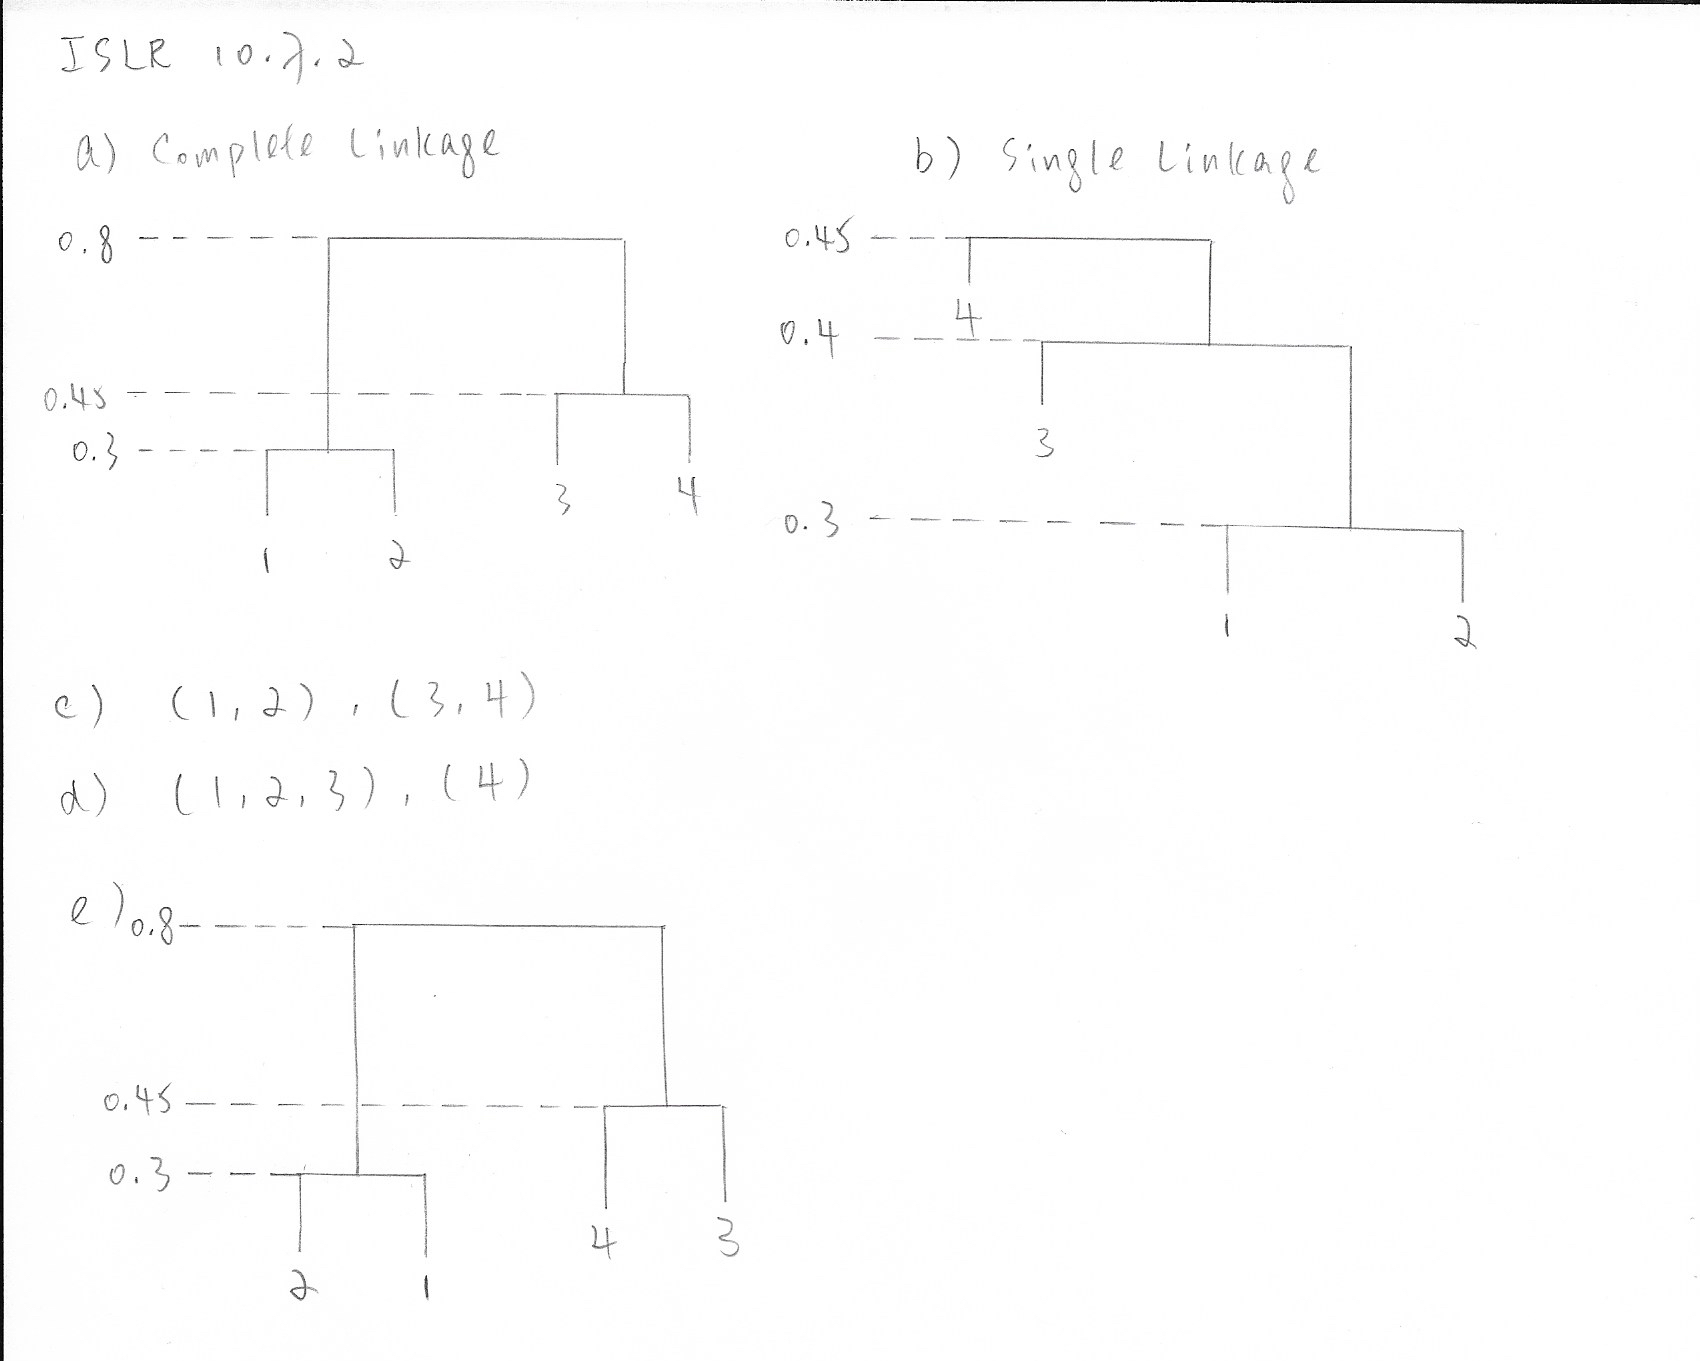

In [16]:
Image('HW5_image/hw5_islr.jpg')